## KDE density contours

A self-contained example of calculating contour levels for the KDE pdf estimate. 

In [3]:
import numpy as np 
from matplotlib.path import Path
from six import string_types
import statsmodels.nonparametric.api as smnp
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

In [4]:
def cumsum_contour_levels(z, inputLevels=[0.683, 0.955, 0.997] ):
    ''' Calculate contour levels encicling x% of the input data. 
    By comparison to a Gaussian distribution, 
    whereby of interest are mean +/- sigma (including 68% of distribution)  , 
    mean +/- 2 sigma (95%),  mean +/- 3 sigma (99.7%),
    we calculate levels that include 68%, 95%, and 99.7% of
    the input data. 
    
    This is done on the input  Kernel Density Estimate of the 
    underlying pdf, z. Eg.
    xx, yy, z = _statsmodels_bivariate_kde(x[m], y[m],'scott',100,3,None),
    where _statsmodels_bivariate_kde is afunction from seaborn 
    calling statsmodels to evaluate bivariate KDE using 
    Scott`s rule for band width, selecting a 100x100 grid, 
    
    We sort the pdf `pixels`, calculate the cumulative sum, 
    normalize it to a range (0,1) and  select those pixels that are 
    above desired levels, eg. 1-0.997, 1-0.955, 1-.683.
    
    Example use : 
    -------------
    # simulate input data 
    xs = np.random.normal(0,1,5000)
    ys =  np.random.normal(1,2,5000)
    
    # evaluate KDE pdf with Scotts rule, on a grid 
    # 100x100 
    xx, yy, z = _statsmodels_bivariate_kde(xs, ys,'scott',100,3,None)
    
    # initialize plotting space 
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    
    # plot just the input data 
    ax.scatter(xs, ys, s=2, lw=0, c='k', alpha=0.5)   
    
    # find the contour levels 
    z_levels = cumsum_contour_levels(z)
    
    # plot the KDE contours 
    outline = ax.contour(xx,yy,z , levels = z_levels, colors='r')
    
    
    Parameters:
    ------------
    z : KDE pdf, a meshgrid of values 
    inputLevels : an array of percentages of data to include 
        in the contours to calculate 
        
    Returns:
    ----------
    z_cum_levels : values of the input KDE pdf for the appropriate
        contour levels 
    '''

    # record the shape of the input array,
    # so that  z_ravel.reshape(shape) == z 
    shape = z.shape
    z_ravel = z.ravel()

    # indices to sorted array 
    i_sort = np.argsort(z_ravel)
    # and a way to unsort ...
    # so that z_ravel == z_ravel_sort[i_unsort] 
    i_unsort  = np.argsort(i_sort) 
    z_ravel_sort = z_ravel[i_sort]

    # according to idea from here
    # https://stats.stackexchange.com/questions/68105/contours-containing-a-given-fraction-of-x-y-points
    # to plot contours with a fraction of points, 
    # we compute a kernel density estimate on a fine grid and select 
    # the largest 68%, 95%, or 99% from the cumulative sum of its 
    # sorted values: they form a region within the grid.

    # calculate the cumulative sum 
    # for the sorted array 
    # that is, if we have 
    # a = [1,2,3,4,5...] , then 
    # a.cumsum() = [1,1+2, 1+2+3, 1+2+3+4, 1+2+3+4+5...]
    #vhttps://blog.finxter.com/numpy-cumsum/
    z_ravel_sort_cumsum = z_ravel_sort.cumsum()
    z_ravel_sort_cumsum /= z_ravel_sort_cumsum[-1]
    
    z_cum_levels = []
    cumsum_levels = np.sort(1-np.array(inputLevels))
    print('\nPicking KDE pdf pixels that would include \
    the following percentages of the input data:')
    print(inputLevels)
    for level in cumsum_levels : 
        mc_sort  = z_ravel_sort_cumsum > level # mask to sorted unravelled array
        # find the lowest value of the pdf 
        # that contributed to above that cumsum level
        # from the sorted pdf array 
        z_edge = min(z_ravel_sort[mc_sort])
        z_cum_levels.append(z_edge)

    return z_cum_levels
  

def count_points_inside_contour(x,y,outline):
    ''' Calculate the number of datapoints inside the contour -
    inspired by astroML.plotting.scatter_contour()'''
    X = np.hstack([x[:, None], y[:, None]])
    print('\nhow many input datapoints are within each outline')
    for i in range(np.shape(outline.allsegs)[0]):
        outer_poly = outline.allsegs[i][0]
        points_inside = Path(outer_poly).contains_points(X)
        N_inside = np.sum(points_inside)
        N_total = len(x)
        print('%d/%d, i.e. %.2f%%'% (N_inside,N_total,100*N_inside/N_total,))
    Xplot = X[~points_inside]
    # to plot the points that are outside given contour,
    # use 
    #ax.scatter(Xplot[:, 0], Xplot[:, 1], zorder=1, )
    

# The functions below are from sns.kdeplot

def _kde_support(data, bw, gridsize, cut, clip):
    """Establish support for a kernel density estimate."""
    support_min = max(data.min() - bw * cut, clip[0])
    support_max = min(data.max() + bw * cut, clip[1])
    return np.linspace(support_min, support_max, gridsize)


def _statsmodels_bivariate_kde(x, y, bw, gridsize, cut, clip):
    """Compute a bivariate kde using statsmodels."""
    
    if clip is None:
        clip = [(-np.inf, np.inf), (-np.inf, np.inf)]
    elif np.ndim(clip) == 1:
        clip = [clip, clip]
        
    if isinstance(bw, string_types):
        bw_func = getattr(smnp.bandwidths, "bw_" + bw)
        # this is equivalent to 
        # smnp.bandwidths.bw_scott(x[m])
        x_bw = bw_func(x)
        y_bw = bw_func(y)
        bw = [x_bw, y_bw]
    elif np.isscalar(bw):
        bw = [bw, bw]

    if isinstance(x, pd.Series):
        x = x.values
    if isinstance(y, pd.Series):
        y = y.values
    #print(bw)
    
    # initialize the kernel density estimation object
    kde = smnp.KDEMultivariate([x, y], "cc", bw)
    
    # span the "KDE support grid" - basically 
    # the grid on which we want to probe the pdf, 
    # which is continuous - so we are essentially 
    # discretizing a continuous distribution to visualize it 
    x_support = _kde_support(x, kde.bw[0], gridsize, cut, clip[0])
    y_support = _kde_support(y, kde.bw[1], gridsize, cut, clip[1])
    xx, yy = np.meshgrid(x_support, y_support)
    # this evaluates a method that prints the probability density function
    # at the grid positions given the data 
    z = kde.pdf([xx.ravel(), yy.ravel()]).reshape(xx.shape)
    return xx, yy, z


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



Picking KDE pdf pixels that would include     the following percentages of the input data:
[0.683, 0.955, 0.997]

how many input datapoints are within each outline
1/5000, i.e. 0.02%
4813/5000, i.e. 96.26%
3493/5000, i.e. 69.86%


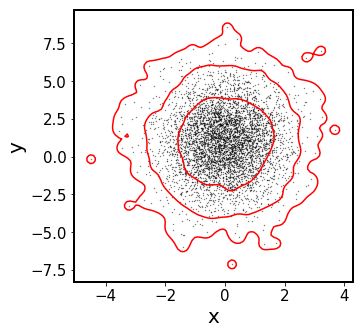

In [5]:
%matplotlib inline

# Example use : 
xs = np.random.normal(0,1,5000)
ys =  np.random.normal(1,2,5000)

# evaluate KDE pdf with Scotts rule, on a grid 100x100 
xx, yy, z = _statsmodels_bivariate_kde(xs, ys,'scott',100,3,None)

# initialize plotting space 
fig,ax = plt.subplots(1,1,figsize=(5,5))

# plot just the input data 
ax.scatter(xs, ys, s=2, lw=0, c='k', alpha=0.5)   

# find the contour levels 
z_levels = cumsum_contour_levels(z)

# plot the KDE contours 
outline = ax.contour(xx,yy,z , levels = z_levels, colors='r')

ax.set_xlabel('x')
ax.set_ylabel('y')

# count the points in each contour...
count_points_inside_contour(xs,ys,outline)
